### This tutorial demostrate how to design a custom loss formulated as follows:

## $$loss = \alpha \times loss_1 + \beta \times loss_2$$

In [1]:
# import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# set to plot in the notebook
%matplotlib inline 

# import keras (using tensorflow backend)
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.visible_device_list= '0'
set_session(tf.Session(config=config))

In [3]:
from keras.datasets import cifar10

# set batch size and number of classes
input_shape = (32,32,3)
batch_size = 500
num_classes = 10
epochs = 10

# load cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# convert class vectors to one-hot binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# normalize data to [-1, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 127.5
x_test /= 127.5
x_train -= 1.
x_test -= 1.

In [4]:
from keras.models import Sequential

from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def cnn_model(input_shape, num_classes):    
    model = Sequential()

    # conv1
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=input_shape))
    model.add(Activation('relu'))
    # pool1
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))

    # conv2
    model.add(Conv2D(64, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    # pool2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))

    # fc1
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))

    # fc2
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

model = cnn_model(input_shape, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

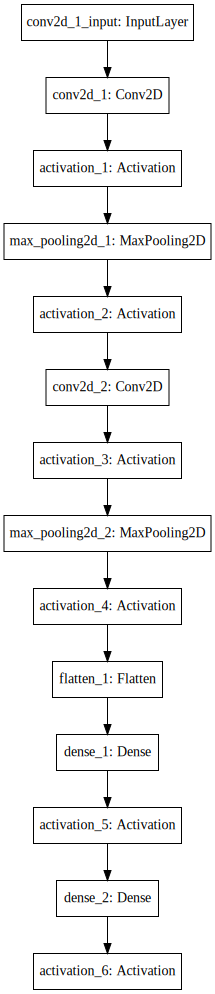

In [5]:
# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# or you can save model diagram by following code
#from keras.utils import plot_model
#plot_model(model, to_file='cnn_model.png')

In [6]:
import keras.backend as K
def cosine_proximity(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return -K.sum(y_true * y_pred, axis=-1)
def categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred)
def custom_loss(y_true, y_pred):
    return 0.2*cosine_proximity(y_true, y_pred) + 0.8*categorical_crossentropy(y_true, y_pred)
loss = custom_loss

# compile model
optimizer = keras.optimizers.sgd()
metric = keras.metrics.categorical_accuracy
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

# import image data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

# Compute quantities required for feature-wise normalization
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test))

Epoch 1/10
100/100 [==============================] - 2s 24ms/step - loss: 1.7408 - categorical_accuracy: 0.1826 - val_loss: 1.6907 - val_categorical_accuracy: 0.2326
Epoch 2/10
100/100 [==============================] - 2s 15ms/step - loss: 1.6471 - categorical_accuracy: 0.2399 - val_loss: 1.5947 - val_categorical_accuracy: 0.2576
Epoch 3/10
100/100 [==============================] - 2s 15ms/step - loss: 1.5605 - categorical_accuracy: 0.2701 - val_loss: 1.5142 - val_categorical_accuracy: 0.2911
Epoch 4/10
100/100 [==============================] - 2s 15ms/step - loss: 1.4887 - categorical_accuracy: 0.3034 - val_loss: 1.4470 - val_categorical_accuracy: 0.3258
Epoch 5/10
100/100 [==============================] - 1s 15ms/step - loss: 1.4255 - categorical_accuracy: 0.3322 - val_loss: 1.3895 - val_categorical_accuracy: 0.3488
Epoch 6/10
100/100 [==============================] - 2s 15ms/step - loss: 1.3736 - categorical_accuracy: 0.3551 - val_loss: 1.3425 - val_categorical_accuracy: 0.366

In [7]:
[train_loss, train_acc] = history.model.evaluate(x=x_train, y=y_train, batch_size=batch_size, verbose=0)
print("Train accuracy:{0:.2f}%.".format(train_acc*100))

Train accuracy:42.36%.


In [8]:
[test_loss, test_acc] = history.model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0)
print("Test accuracy:{0:.2f}%.".format(test_acc*100))

Test accuracy:42.41%.
